# Animated graphs

# 0. Constants

In [45]:
# =================================================
# Animation export settings
# =================================================

# Choose output format: "mp4" or "gif"
ANIM_FORMAT = "gif"   # <-- переключатель

# Common animation parameters
FPS = 24
DPI = 150

# Video / GIF specifics
MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"   # pillow = safest
GIF_LOOP = 0            # 0 = infinite loop

# =================================================
# Theme settings
# =================================================

# Choose theme: "light" or "dark"
THEME = "dark"   # <-- переключатель


print(f"Animation format: {ANIM_FORMAT}")
print(f"Theme: {THEME}")


Animation format: gif
Theme: dark


## 1. Paths and imports

In [31]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- project root ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

# --- output ---
OUT_DIR = topic_root / "animations"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Topic:", topic_root)
print("Animations:", OUT_DIR)

Topic: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
Animations: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations


## 2. Theme

In [46]:
import matplotlib.pyplot as plt

def apply_theme(theme="light"):
    if theme == "light":
        plt.style.use("default")

        plt.rcParams.update({
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "axes.edgecolor": "black",
            "axes.labelcolor": "black",
            "text.color": "black",
            "xtick.color": "black",
            "ytick.color": "black",
            "grid.color": "#cccccc",
            "grid.alpha": 0.6,
            "legend.frameon": False,
        })

    elif theme == "dark":
        plt.style.use("dark_background")

        plt.rcParams.update({
            "figure.facecolor": "#0f1116",
            "axes.facecolor": "#0f1116",
            "axes.edgecolor": "#e0e0e0",
            "axes.labelcolor": "#e0e0e0",
            "text.color": "#e0e0e0",
            "xtick.color": "#e0e0e0",
            "ytick.color": "#e0e0e0",
            "grid.color": "#444444",
            "grid.alpha": 0.4,
            "legend.frameon": False,
        })

    else:
        raise ValueError("THEME must be 'light' or 'dark'")

apply_theme(THEME)

## 3. Label dictionary (EN/RU)

In [33]:
LABELS = {
    "count": "Count",
    "norm": "Normalized density",
    "rbirth": r"$r_{\rm birth}$ (kpc)",
    "feh": r"[Fe/H] (dex)",
    "teff": r"$T_{\rm eff}$ (K)",
    "logg": r"$\log g$",
    "toy": "Toy",
    "minchev": "Minchev-like",
    "single": "single stars",
    "hosts": "host stars",
}

## 4.Save animation helper (mp4 preferred)

In [34]:
from pathlib import Path
from matplotlib.animation import FFMpegWriter, PillowWriter
import matplotlib

print("matplotlib:", matplotlib.__version__)

def save_animation(anim, out_path_base: Path):
    """
    Save matplotlib animation as MP4 or GIF depending on ANIM_FORMAT.
    Prints the exact output path and verifies file existence.
    """
    out_path_base = Path(out_path_base)
    out_path_base.parent.mkdir(parents=True, exist_ok=True)

    if ANIM_FORMAT.lower() == "mp4":
        out_file = out_path_base.with_suffix(".mp4")
        print("Target:", out_file.resolve())

        writer = FFMpegWriter(
            fps=FPS,
            codec=MP4_CODEC,
            bitrate=MP4_BITRATE
        )
        anim.save(out_file, writer=writer, dpi=DPI)
        print("Saved:", out_file.resolve(), "exists:", out_file.exists())
        return out_file

    elif ANIM_FORMAT.lower() == "gif":
        out_file = out_path_base.with_suffix(".gif")
        print("Target:", out_file.resolve())

        # PillowWriter is safest; loop is not supported in some older mpl versions
        try:
            writer = PillowWriter(fps=FPS, loop=GIF_LOOP)
        except TypeError:
            writer = PillowWriter(fps=FPS)

        anim.save(out_file, writer=writer, dpi=DPI)
        print("Saved:", out_file.resolve(), "exists:", out_file.exists())
        return out_file

    else:
        raise ValueError("ANIM_FORMAT must be 'mp4' or 'gif'")

matplotlib: 3.10.3


## 5. Animations

### 5.0. Theme support

In [47]:
if THEME == "dark":
    COLORS = {
        "toy": "#4cc9f0",        # cyan
        "minchev": "#f72585",    # magenta
        "single": "#7ae582",
        "host": "#ffb703",
    }
else:
    COLORS = {
        "toy": "#1f77b4",        # matplotlib blue
        "minchev": "#d62728",    # red
        "single": "#2ca02c",
        "host": "#ff7f0e",
    }

### 5.1. Histogram - linear

In [35]:
def animate_hist_reveal(series_list, labels, colors=None, title="", xlabel="", bins=30, rmin=None, rmax=None,
                       frames=60, interval=33):
    if colors is None:
        colors = [None] * len(series_list)

    fig, ax = plt.subplots(figsize=(10, 5))  # ~16:9
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(LABELS["norm"])
    ax.grid(True, alpha=0.25)

    # fixed range
    data_all = np.concatenate([s.values for s in series_list if len(s) > 0])
    if rmin is None: rmin = float(np.nanmin(data_all))
    if rmax is None: rmax = float(np.nanmax(data_all))

    # precompute hist heights
    hist_data = []
    edges = None
    for s in series_list:
        h, e = np.histogram(s, bins=bins, range=(rmin, rmax), density=True)
        hist_data.append(h)
        edges = e

    # --- FIX Y RANGE ---
    ymax = max(h.max() for h in hist_data if len(h) > 0)
    ax.set_ylim(0, ymax * 1.15)  # 15% headroom, как в статье

    # bars (one container per dataset)
    bar_containers = []
    width = edges[1] - edges[0]
    for i, h in enumerate(hist_data):
        bc = ax.bar(edges[:-1], np.zeros_like(h), width=width, align="edge",
                    alpha=0.45, edgecolor="k", label=labels[i], color=colors[i])
        bar_containers.append(bc)

    ax.set_xlim(rmin, rmax)
    ax.legend(loc="upper right")

    def update(frame):
        t = (frame + 1) / frames  # 0..1
        for bc, h in zip(bar_containers, hist_data):
            for rect, hh in zip(bc.patches, h):
                rect.set_height(hh * t)
        return [p for bc in bar_containers for p in bc.patches]

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim

### 5.2. Histogram - equalizer

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def _smooth_1d(x, kernel):
    """Simple 1D convolution smoothing with edge padding."""
    x = np.asarray(x, float)
    k = np.asarray(kernel, float)
    k = k / k.sum()
    pad = len(k) // 2
    xp = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(xp, k, mode="valid")

def animate_hist_equalizer(series_list, labels, colors=None, title="", xlabel="",
                           bins=30, rmin=None, rmax=None,
                           frames=60, interval=33,
                           jitter_strength=0.55, settle_last=6,
                           seed=42,
                           smooth_kernel=(1, 2, 3, 2, 1),
                           smooth_passes=2,
                           noise_clip=(0.0, 2.5)):
    """
    Histogram 'equalizer' animation with smoothed jitter:
    - Bars reveal from 0 to true heights
    - Random multiplicative jitter is smoothed across bins (neighbor-coherent motion)
    - Jitter amplitude decays to 0; last settle_last frames are exact true histogram
    """
    rng = np.random.default_rng(seed)
    if colors is None:
        colors = [None] * len(series_list)

    fig, ax = plt.subplots(figsize=(10, 5))  # ~16:9
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(LABELS["norm"])
    ax.grid(True, alpha=0.25)

    # fixed range
    data_all = np.concatenate([s.values for s in series_list if len(s) > 0])
    if rmin is None: rmin = float(np.nanmin(data_all))
    if rmax is None: rmax = float(np.nanmax(data_all))

    # precompute hist heights (density)
    hist_data = []
    edges = None
    for s in series_list:
        h, e = np.histogram(s, bins=bins, range=(rmin, rmax), density=True)
        hist_data.append(h.astype(float))
        edges = e

    # --- FIX Y RANGE (start at 0, no clipping) ---
    ymax = max(h.max() for h in hist_data if len(h) > 0)
    ax.set_ylim(0, ymax * 1.15)

    # bars (one container per dataset)
    bar_containers = []
    width = edges[1] - edges[0]
    for i, h in enumerate(hist_data):
        bc = ax.bar(edges[:-1], np.zeros_like(h), width=width, align="edge",
                    alpha=0.45, edgecolor="k", label=labels[i], color=colors[i])
        bar_containers.append(bc)

    ax.set_xlim(rmin, rmax)
    ax.legend(loc="upper right")

    # helper: smooth step (nicer than linear)
    def smooth01(t):
        t = np.clip(t, 0, 1)
        return t*t*(3 - 2*t)

    def make_smoothed_noise(nbins, amp):
        # multiplicative noise around 1.0
        # start with raw normal noise; convert to factor ~ 1 + amp * z
        z = rng.normal(0.0, 1.0, nbins)
        for _ in range(max(1, smooth_passes)):
            z = _smooth_1d(z, smooth_kernel)
        factor = 1.0 + amp * z
        return np.clip(factor, noise_clip[0], noise_clip[1])

    def update(frame):
        # progress 0..1
        t = (frame + 1) / frames
        t = smooth01(t)

        # settle: last N frames have zero jitter for perfect final frame
        if frame >= frames - settle_last:
            amp = 0.0
        else:
            amp = jitter_strength * (1.0 - t)

        artists = []
        for bc, h_true in zip(bar_containers, hist_data):
            h_base = h_true * t

            if amp > 0:
                noise = make_smoothed_noise(len(h_true), amp)
                h_draw = h_base * noise
            else:
                h_draw = h_base

            for rect, hh in zip(bc.patches, h_draw):
                rect.set_height(float(hh))
                artists.append(rect)

        return artists

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim

### 5.2. Lines

In [36]:
def animate_lines_draw(x, y_list, labels, title="", xlabel="", ylabel="", colors=None,
                       frames=80, interval=33, ylim=None):
    if colors is None:
        colors = [None]*len(y_list)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)
    if ylim is not None:
        ax.set_ylim(*ylim)

    lines = []
    for y, lab, col in zip(y_list, labels, colors):
        (ln,) = ax.plot([], [], marker="o", linewidth=2, label=lab, color=col)
        lines.append(ln)
    ax.set_xlim(np.min(x), np.max(x))
    ax.legend()

    def update(frame):
        k = int((frame + 1) / frames * len(x))
        k = max(1, min(k, len(x)))
        for ln, y in zip(lines, y_list):
            ln.set_data(x[:k], y[:k])
        return lines

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim

### 5.3. Scatter

In [37]:
def animate_scatter_reveal(x, y, title="", xlabel="", ylabel="", color=None,
                           frames=80, interval=33, s=22):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2)

    n = len(x)
    order = np.argsort(x)  # приятнее “слева направо”
    x = np.asarray(x)[order]
    y = np.asarray(y)[order]

    sc = ax.scatter([], [], s=s, color=color, edgecolors="k", linewidths=0.3)

    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))

    def update(frame):
        k = int((frame + 1) / frames * n)
        k = max(1, min(k, n))
        sc.set_offsets(np.c_[x[:k], y[:k]])
        return (sc,)

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim

---

## 6. Examples

### 6.1. Figure 1. Distribution of host stars by effective temperature for both data samples

SWEET: 1183 | HARPS single: 941 | HARPS host: 170
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_1_combined_LR.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_1_combined_LR.gif exists: True


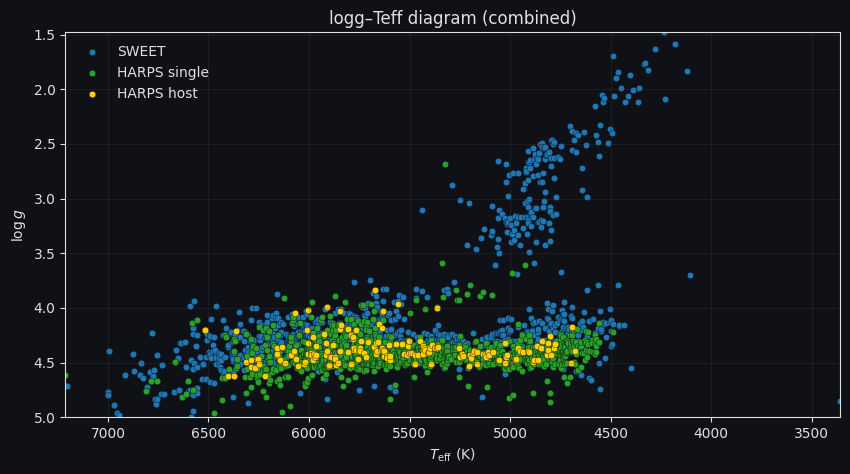

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_1_combined_RANDOM.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_1_combined_RANDOM.gif exists: True


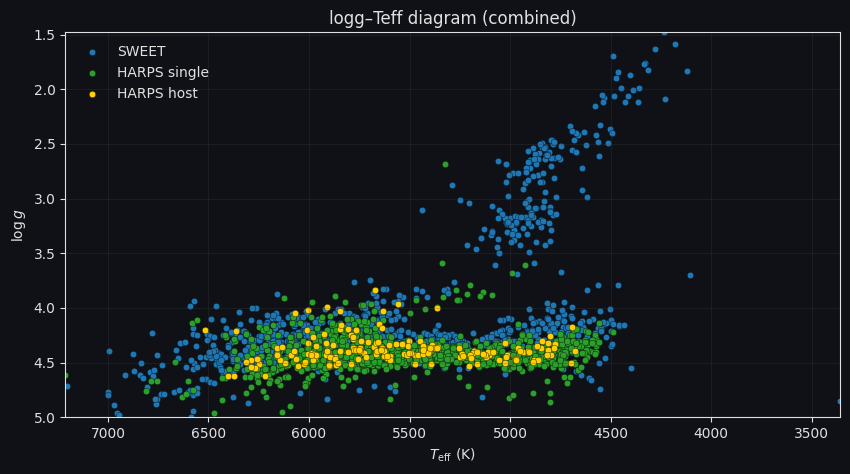

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from astroquery.vizier import Vizier
import re

# ---------- load SWEET ----------
sweet = pd.read_csv(topic_root / "data/raw/sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()
sweet = sweet[["Teff", "Logg"]].dropna()
sweet = sweet[(sweet["Teff"] > 0) & (sweet["Logg"] > 0)].copy()

# ---------- load HARPS ----------
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()
harps = harps.dropna(subset=["Teff", "logg"]).copy()
harps = harps[(harps["Teff"] > 0) & (harps["logg"] > 0)].copy()

# ---------- load NEA to identify hosts ----------
nea = pd.read_csv(topic_root / "data/raw/nea_ps_default_flag_1.csv")

def canon_name(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9+\- ]", "", s)
    s = s.replace(" ", "")
    return s

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

host_col = pick_col(nea, ["hostname","pl_hostname","star_name","host_name","host","sy_name"])
nea_hosts = set(nea[host_col].dropna().map(canon_name).tolist())

harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)
harps["is_host"] = harps["name1"].isin(nea_hosts) | harps["name2"].isin(nea_hosts)

harps_single = harps[~harps["is_host"]].copy()
harps_host   = harps[ harps["is_host"]].copy()

print("SWEET:", len(sweet), "| HARPS single:", len(harps_single), "| HARPS host:", len(harps_host))

# ---------- animation ----------
def anim_logg_teff_combined(sweet_df, harps_single_df, harps_host_df,
                            mode="lr", points_per_frame=60, frames=120, seed=42):

    # pack into one table so we can control ordering globally
    df = pd.concat([
        pd.DataFrame({"Teff": sweet_df["Teff"].values, "logg": sweet_df["Logg"].values, "cls": "SWEET"}),
        pd.DataFrame({"Teff": harps_single_df["Teff"].values, "logg": harps_single_df["logg"].values, "cls": "HARPS_single"}),
        pd.DataFrame({"Teff": harps_host_df["Teff"].values, "logg": harps_host_df["logg"].values, "cls": "HARPS_host"}),
    ], ignore_index=True).dropna()

    # ordering
    rng = np.random.default_rng(seed)
    if mode == "random":
        order = rng.permutation(len(df))
    elif mode == "lr":
        # IMPORTANT: axes will be inverted; screen-left corresponds to HIGH Teff.
        # So "left-to-right on screen" => reveal by decreasing Teff.
        order = np.argsort(-df["Teff"].values)  # high -> low
    else:
        raise ValueError("mode must be 'lr' or 'random'")

    df = df.iloc[order].reset_index(drop=True)

    # colors (as requested)
    c_sweet  = "tab:blue"
    c_single = "tab:green"
    c_host   = "#FFD000"  # yellow (readable on dark too)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("logg–Teff diagram (combined)")
    ax.set_xlabel(LABELS["teff"])
    ax.set_ylabel(LABELS["logg"])
    ax.grid(True, alpha=0.25)

    # paper style
    ax.invert_xaxis()
    ax.invert_yaxis()

    # fixed limits
    xmin, xmax = df["Teff"].min(), df["Teff"].max()
    ymin, ymax = df["logg"].min(), df["logg"].max()
    ax.set_xlim(xmax, xmin)  # because inverted
    ax.set_ylim(ymax, ymin)

    # three scatters (faster than per-point coloring in one scatter)
    sc_sweet  = ax.scatter([], [], s=22, color=c_sweet,  edgecolors="k", linewidths=0.25, label="SWEET")
    sc_single = ax.scatter([], [], s=22, color=c_single, edgecolors="k", linewidths=0.25, label="HARPS single")
    sc_host   = ax.scatter([], [], s=22, color=c_host,   edgecolors="k", linewidths=0.25, label="HARPS host")

    ax.legend(loc="upper left")

    # pre-split indices by class for fast incremental offsets
    x = df["Teff"].to_numpy()
    y = df["logg"].to_numpy()
    cls = df["cls"].to_numpy()

    # store growing lists
    xs, ys = [], []
    xg, yg = [], []
    xy, yy = [], []

    total = len(df)
    max_points = min(total, points_per_frame * frames)

    def update(f):
        start = f * points_per_frame
        end = min((f + 1) * points_per_frame, max_points)

        if start >= end:
            return (sc_sweet, sc_single, sc_host)

        # add batch
        for i in range(start, end):
            if cls[i] == "SWEET":
                xs.append(x[i]); ys.append(y[i])
            elif cls[i] == "HARPS_single":
                xg.append(x[i]); yg.append(y[i])
            else:
                xy.append(x[i]); yy.append(y[i])

        sc_sweet.set_offsets(np.c_[xs, ys] if xs else np.empty((0, 2)))
        sc_single.set_offsets(np.c_[xg, yg] if xg else np.empty((0, 2)))
        sc_host.set_offsets(np.c_[xy, yy] if xy else np.empty((0, 2)))

        return (sc_sweet, sc_single, sc_host)

    anim = FuncAnimation(fig, update, frames=frames, interval=1000 / FPS, blit=False)
    return anim

# --- 1) left-to-right (screen) ---
anim_lr = anim_logg_teff_combined(sweet, harps_single, harps_host,
                                  mode="lr", points_per_frame=70, frames=110, seed=1)
save_animation(anim_lr, OUT_DIR / "ANIM_Figure_1_combined_LR")
plt.show()

# --- 2) random order ---
anim_rand = anim_logg_teff_combined(sweet, harps_single, harps_host,
                                    mode="random", points_per_frame=70, frames=110, seed=2)
save_animation(anim_rand, OUT_DIR / "ANIM_Figure_1_combined_RANDOM")
plt.show()

### 6.2. Figure 2 — [Fe/H] distributions (strict + equalizer)

SWEET [Fe/H]: 1264
HARPS single [Fe/H]: 941
HARPS host [Fe/H]: 170
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_2_FeH_STRICT.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_2_FeH_STRICT.gif exists: True


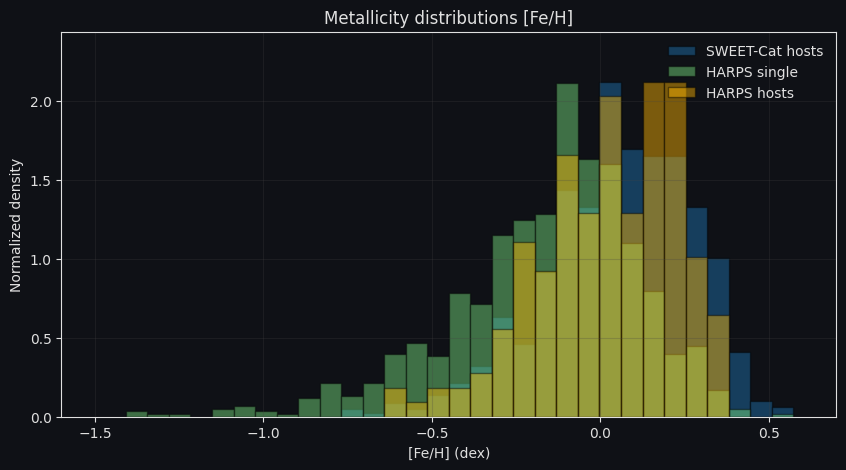

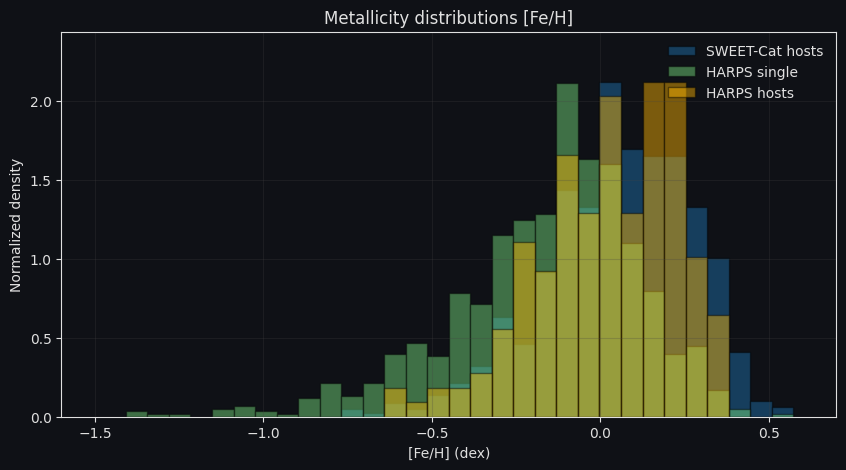

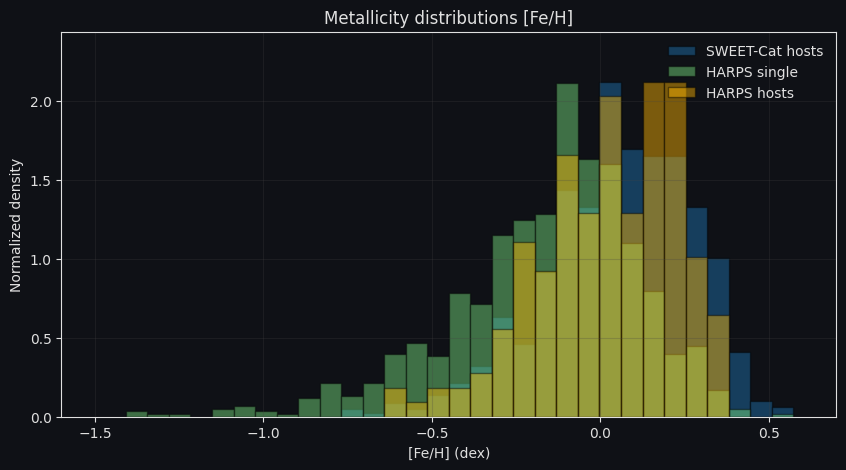

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_2_FeH_EQUALIZER.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_2_FeH_EQUALIZER.gif exists: True


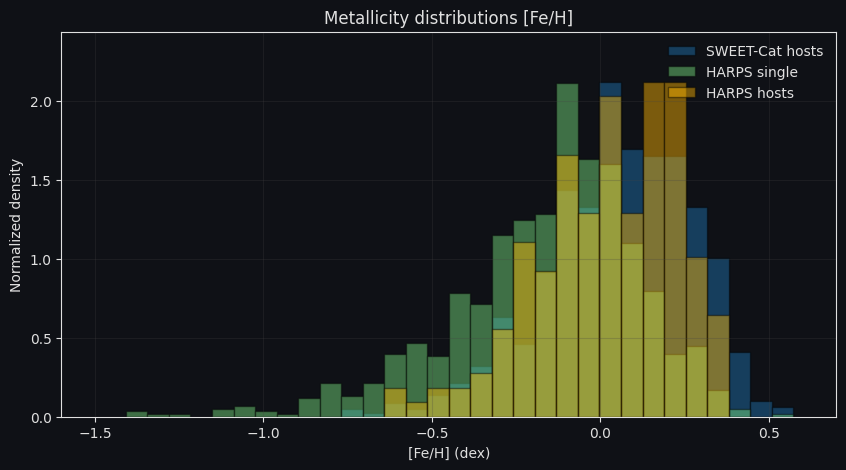

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from astroquery.vizier import Vizier
import re

# ---------- load data ----------
# SWEET hosts
sweet = pd.read_csv(topic_root / "data/raw/sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()
sweet_feh = sweet["[Fe/H]"].dropna()

# HARPS
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()
harps = harps.dropna(subset=["[Fe/H]"]).copy()

# NEA hosts set
nea = pd.read_csv(topic_root / "data/raw/nea_ps_default_flag_1.csv")

def canon_name(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9+\- ]", "", s)
    s = s.replace(" ", "")
    return s

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

host_col = pick_col(nea, ["hostname","pl_hostname","star_name","host_name","host","sy_name"])
nea_hosts = set(nea[host_col].dropna().map(canon_name).tolist())

harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)
harps["is_host"] = harps["name1"].isin(nea_hosts) | harps["name2"].isin(nea_hosts)

harps_single_feh = harps.loc[~harps["is_host"], "[Fe/H]"].dropna()
harps_host_feh   = harps.loc[ harps["is_host"], "[Fe/H]"].dropna()

print("SWEET [Fe/H]:", len(sweet_feh))
print("HARPS single [Fe/H]:", len(harps_single_feh))
print("HARPS host [Fe/H]:", len(harps_host_feh))

# ---------- axis range (paper-ish, stable) ----------
rmin, rmax = -1.6, 0.7
bins = 36
frames = 80

# ---------- 1) strict reveal ----------
anim_strict = animate_hist_reveal(
    [sweet_feh, harps_single_feh, harps_host_feh],
    labels=["SWEET-Cat hosts", "HARPS single", "HARPS hosts"],
    colors=["tab:blue", COLORS.get("single","tab:green"), COLORS.get("host","#FFD000")],
    title="Metallicity distributions [Fe/H]",
    xlabel=LABELS.get("feh", "[Fe/H] (dex)"),
    bins=bins, rmin=rmin, rmax=rmax,
    frames=frames,
    interval=1000 / FPS
)
save_animation(anim_strict, OUT_DIR / "ANIM_Figure_2_FeH_STRICT")
plt.show()

# ---------- 2) equalizer reveal ----------
anim_eq = animate_hist_equalizer(
    [sweet_feh, harps_single_feh, harps_host_feh],
    labels=["SWEET-Cat hosts", "HARPS single", "HARPS hosts"],
    colors=["tab:blue", COLORS.get("single","tab:green"), COLORS.get("host","#FFD000")],
    title="Metallicity distributions [Fe/H]",
    xlabel=LABELS.get("feh", "[Fe/H] (dex)"),
    bins=bins, rmin=rmin, rmax=rmax,
    frames=frames + 10,
    interval=1000 / FPS,
    jitter_strength=0.9,
    settle_last=10
)
save_animation(anim_eq, OUT_DIR / "ANIM_Figure_2_FeH_EQUALIZER")
plt.show()

### 6.3. Figure 5. Toy vs GCE models - histogram 

#### 6.3.1. Toy vs GCE - Linear

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_5_Toy_vs_Minchev.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_5_Toy_vs_Minchev.gif exists: True


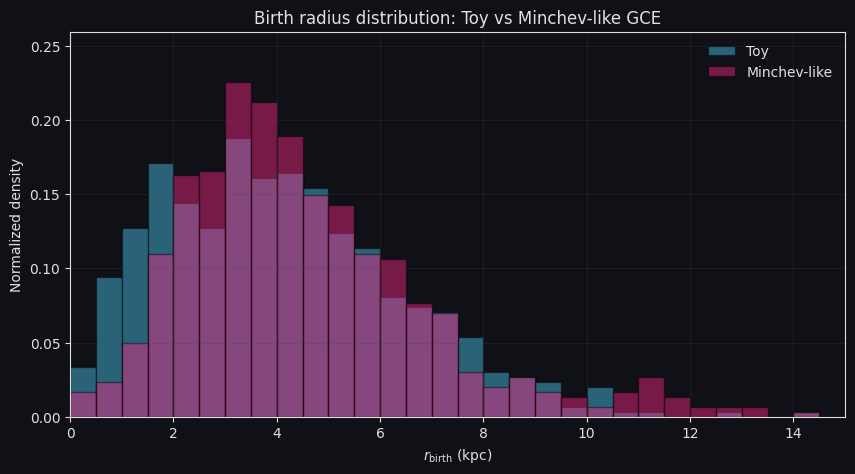

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

gce_path = topic_root / "data/processed/sweetcat_rbirth_gce.csv"
df = pd.read_csv(gce_path)

toy = df["rbirth_toy"].dropna()
minc = df["rbirth_minchev"].dropna()

anim = animate_hist_reveal(
    [toy, minc],
    labels=[LABELS["toy"], LABELS["minchev"]],
    colors=[COLORS.get("toy","tab:blue"), COLORS.get("minchev","tab:red")],
    title="Birth radius distribution: Toy vs Minchev-like GCE",
    xlabel=LABELS["rbirth"],
    bins=30,
    rmin=0.0, rmax=15.0,
    frames=60,
    interval=1000 / FPS,   # sync to global FPS
)

# unified output name (extension decided by ANIM_FORMAT)
save_animation(anim, OUT_DIR / "ANIM_Figure_5_Toy_vs_Minchev")

plt.show()

#### 6.3.2. Toy vs GCE - Equalizer

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_5_Toy_vs_Minchev_eq.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_5_Toy_vs_Minchev_eq.gif exists: True


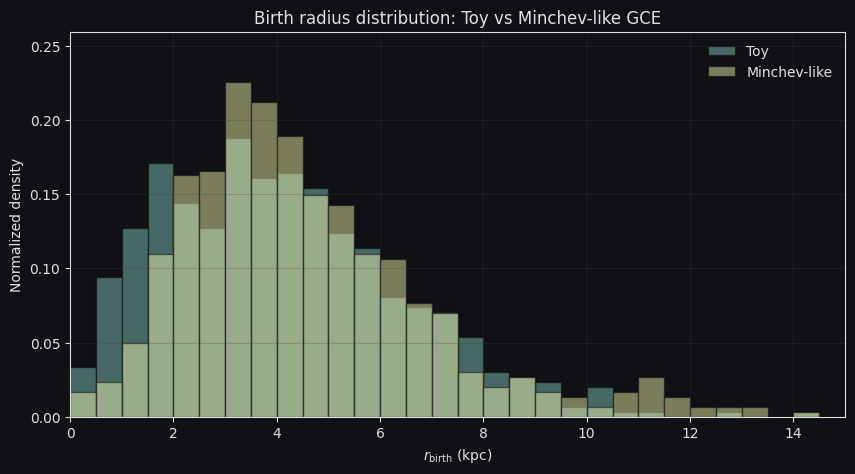

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

gce_path = topic_root / "data/processed/sweetcat_rbirth_gce.csv"
df = pd.read_csv(gce_path)

toy = df["rbirth_toy"].dropna()
minc = df["rbirth_minchev"].dropna()

anim = animate_hist_equalizer(
    [toy, minc],
    labels=[LABELS["toy"], LABELS["minchev"]],
    colors=[COLORS.get("toy","tab:blue"), COLORS.get("minchev","tab:red")],
    title="Birth radius distribution: Toy vs Minchev-like GCE",
    xlabel=LABELS["rbirth"],
    bins=30,
    rmin=0.0, rmax=15.0,
    frames=80,
    interval=1000 / FPS,
    jitter_strength=0.9,
    settle_last=10,
    smooth_kernel=(1, 3, 5, 3, 1),
    smooth_passes=2
)

# unified output name (extension decided by ANIM_FORMAT)
save_animation(anim, OUT_DIR / "ANIM_Figure_5_Toy_vs_Minchev_eq")

plt.show()

### 6.3. Figures 8/9

SWEET class built from NEA masses.
HARPS already has 'class' column.

SWEET classes:
 HMPH    414
LMPH     76
Name: class, dtype: int64

HARPS classes:
 single    385
HMPH       66
LMPH       15
Name: class, dtype: int64
SWEET rows: 490 HARPS rows: 466
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_8_SWEET_Age.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_8_SWEET_Age.gif exists: True


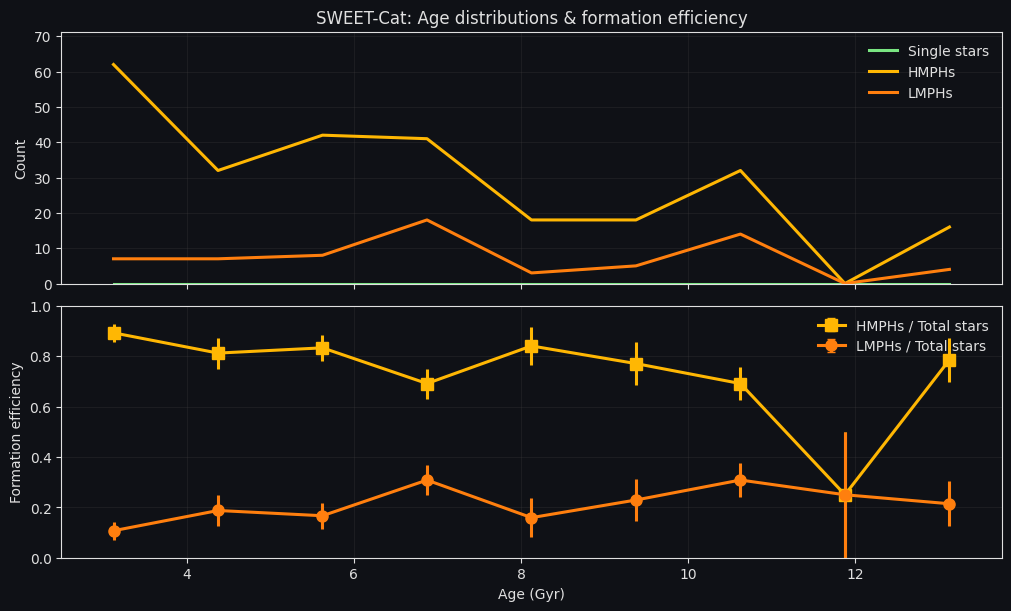

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_8_HARPS_Age.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_8_HARPS_Age.gif exists: True


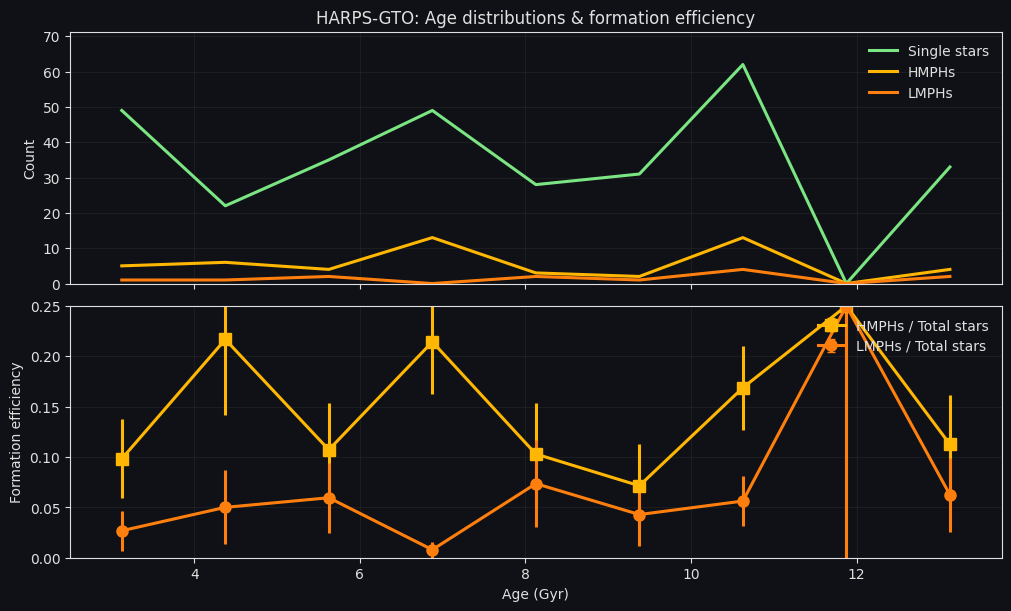

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_9_SWEET_rbirth.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_9_SWEET_rbirth.gif exists: True


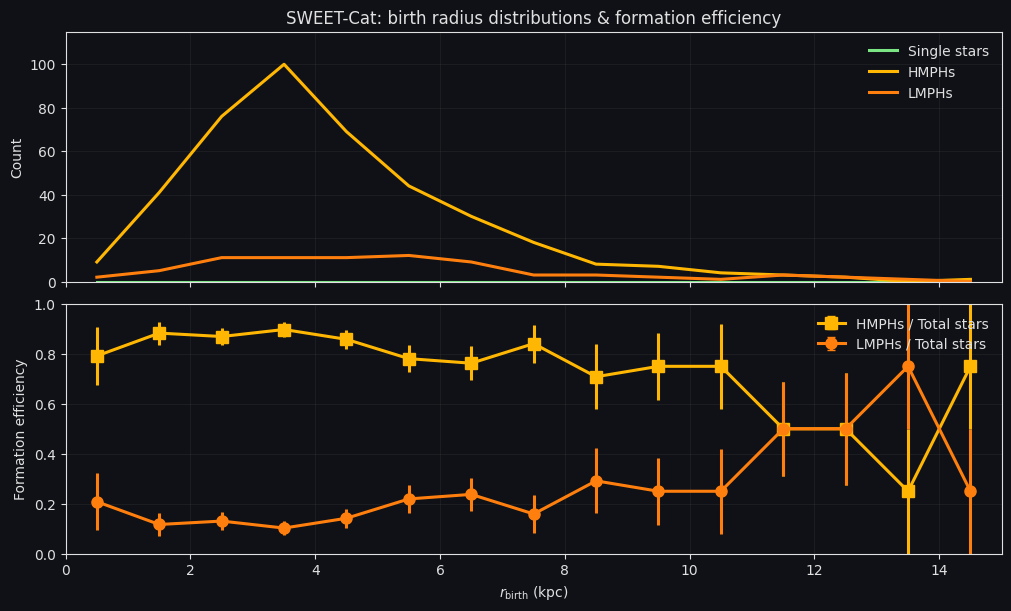

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_9_HARPS_rbirth.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_Figure_9_HARPS_rbirth.gif exists: True


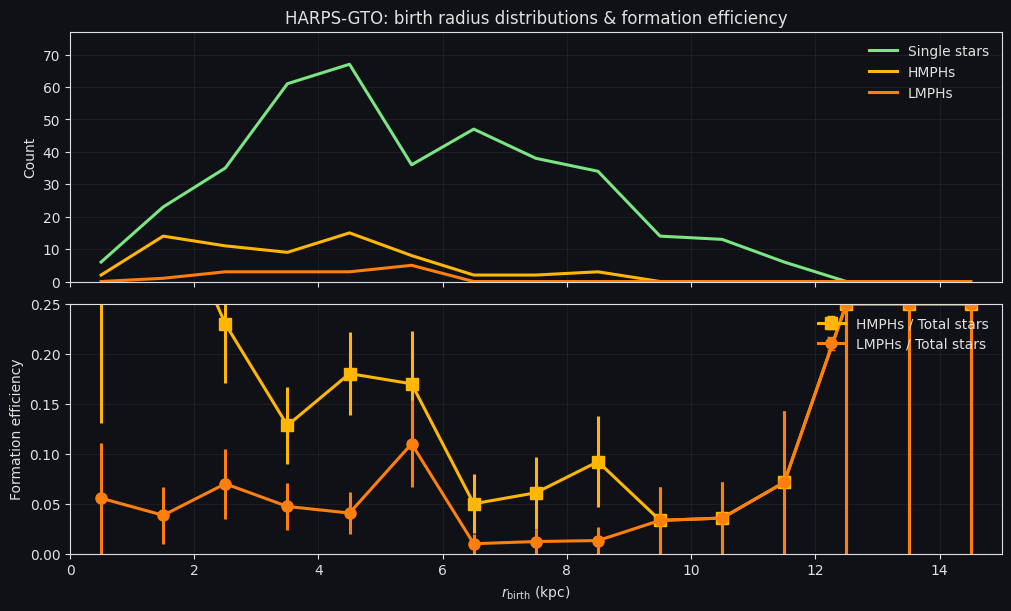

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path
import re

# ==============================
# CONFIG
# ==============================
HMPH_MASS_THRESHOLD_MJ = 0.25   # порог (M_J). Можно подвинуть под статью
AGE_MIN, AGE_MAX = 0.0, 13.5
RB_MIN, RB_MAX = 0.0, 20.0

sweet_proc_path = topic_root / "data/processed/sweetcat_rbirth_gce.csv"
harps_proc_path = topic_root / "data/processed/harps_rbirth_gce.csv"

sweet_raw_path  = topic_root / "data/raw/sweetcat.csv"
nea_path        = topic_root / "data/raw/nea_ps_default_flag_1.csv"

# ==============================
# HELPERS
# ==============================
def canon_name(x):
    if pd.isna(x): 
        return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9+\- ]", "", s)
    s = s.replace(" ", "")
    return s

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def find_mass_mj(nea: pd.DataFrame) -> pd.Series:
    """
    Return a Series of planet mass in Jupiter masses for each NEA row.
    Tries common NEA columns. Converts Earth masses if needed.
    """
    # Jupiter-mass candidates
    mj = pick_col(nea, ["pl_bmassj", "pl_massj", "pl_msinij", "pl_bmassj_reflink", "pl_massj_reflink"])
    if mj is not None and pd.api.types.is_numeric_dtype(nea[mj]):
        return nea[mj]

    # Earth-mass candidates
    me = pick_col(nea, ["pl_bmasse", "pl_masse", "pl_msinie"])
    if me is not None and pd.api.types.is_numeric_dtype(nea[me]):
        return nea[me] / 317.828  # M_earth -> M_jup

    # If not found, return NaNs
    return pd.Series([np.nan]*len(nea), index=nea.index)

def attach_star_class_from_nea(df: pd.DataFrame, name_col_df: str, nea: pd.DataFrame, host_col_nea: str) -> pd.DataFrame:
    """
    Adds df['class'] based on maximum planet mass per host:
    HMPH if max(Mp) >= threshold else LMPH.
    """
    tmp = df.copy()
    tmp["_key"] = tmp[name_col_df].map(canon_name)

    nea2 = nea.copy()
    nea2["_hostkey"] = nea2[host_col_nea].map(canon_name)

    mp_mj = find_mass_mj(nea2)
    nea2["_mp_mj"] = mp_mj

    # max mass per host
    host_max = nea2.groupby("_hostkey")["_mp_mj"].max()

    tmp["_max_mj"] = tmp["_key"].map(host_max)
    tmp = tmp.dropna(subset=["_max_mj"]).copy()  # если нет масс — выбрасываем (иначе не классифицировать честно)

    tmp["class"] = np.where(tmp["_max_mj"] >= HMPH_MASS_THRESHOLD_MJ, "HMPH", "LMPH")
    return tmp.drop(columns=["_key"], errors="ignore")

def clean_df(df, rb_col):
    df = df.copy()
    df = df.dropna(subset=["age_gyr", rb_col])
    df = df[(df["age_gyr"] >= AGE_MIN) & (df["age_gyr"] <= AGE_MAX)]
    df = df[(df[rb_col] >= RB_MIN) & (df[rb_col] <= RB_MAX)]
    return df

# ==============================
# LOAD PROCESSED
# ==============================
sweet = pd.read_csv(sweet_proc_path)
harps = pd.read_csv(harps_proc_path)

rb_sweet = pick_col(sweet, ["rbirth_kpc", "rbirth_minchev", "rbirth"])
rb_harps = pick_col(harps, ["rbirth_kpc", "rbirth_minchev", "rbirth"])
if rb_sweet is None or rb_harps is None:
    raise KeyError("Cannot find r_birth column in SWEET/HARPS processed tables.")

sweet = clean_df(sweet, rb_sweet)
harps = clean_df(harps, rb_harps)

# ==============================
# ENSURE CLASS COLUMN
# ==============================
nea = pd.read_csv(nea_path)
host_col = pick_col(nea, ["hostname", "pl_hostname", "host_name", "sy_name", "star_name"])
if host_col is None:
    raise KeyError("Cannot find host name column in NEA file.")

# SWEET: if no 'class' -> build from NEA (using raw SWEET names)
if "class" not in sweet.columns:
    # Need a name column in SWEET processed to map to hosts
    name_sweet = pick_col(sweet, ["Name", "name", "star", "hostname"])
    if name_sweet is None:
        # fallback: load raw sweetcat and merge by row order is unsafe, so we require Name
        raise KeyError("SWEET processed file has no 'class' and no usable name column (expected 'Name').")

    sweet = attach_star_class_from_nea(sweet, name_sweet, nea, host_col)

    # SWEET has no singles by design; create explicit 'single' absent is fine (counts will be 0)
    print("SWEET class built from NEA masses.")
else:
    print("SWEET already has 'class' column.")

# HARPS: if no 'class' -> build hosts/singles from NEA overlap, then HMPH/LMPH by max planet mass
if "class" not in harps.columns:
    # name columns for harps
    name_h1 = pick_col(harps, ["SimbadName", "Star", "Name"])
    if name_h1 is None:
        raise KeyError("HARPS processed file has no 'class' and no usable name column.")

    tmp = harps.copy()
    tmp["_key"] = tmp[name_h1].map(canon_name)

    nea_hosts = set(nea[host_col].dropna().map(canon_name).tolist())
    tmp["is_host"] = tmp["_key"].isin(nea_hosts)

    # classify hosts by mass threshold, singles remain 'single'
    tmp_host = tmp[tmp["is_host"]].copy()
    tmp_single = tmp[~tmp["is_host"]].copy()
    tmp_single["class"] = "single"

    tmp_host = attach_star_class_from_nea(tmp_host, name_h1, nea, host_col)

    harps = pd.concat([tmp_single, tmp_host], ignore_index=True)
    harps = harps.drop(columns=["_key"], errors="ignore")
    print("HARPS class built from NEA overlap + masses.")
else:
    print("HARPS already has 'class' column.")

print("\nSWEET classes:\n", sweet["class"].value_counts())
print("\nHARPS classes:\n", harps["class"].value_counts())

# ==============================
# WILSON + BIN COUNTS
# ==============================
def wilson_interval(k, n, z=1.0):
    k = np.asarray(k, float)
    n = np.asarray(n, float)
    p = np.divide(k, n, out=np.zeros_like(k), where=(n > 0))
    nn = np.where(n > 0, n, 1.0)
    denom = 1 + z**2 / nn
    center = (p + z**2 / (2*nn)) / denom
    half = (z * np.sqrt((p*(1-p) + z**2/(4*nn)) / nn)) / denom
    lo = np.clip(center - half, 0, 1)
    hi = np.clip(center + half, 0, 1)
    return center, lo, hi

def counts_in_bins(df, xcol, bins, label):
    if label not in set(df["class"].unique()):
        return np.zeros(len(bins)-1, dtype=int)
    x = df.loc[df["class"] == label, xcol].to_numpy()
    return np.histogram(x, bins=bins)[0]

def _set_errorbar(container, x, y, yerr):
    line = container.lines[0]
    caplines = container.lines[1]
    barlinecols = container.lines[2]  # may be empty if errorbar was created without yerr

    line.set_data(x, y)

    # clear previous caps/bars safely
    for c in caplines:
        c.set_data([], [])

    if len(barlinecols) > 0:
        for bc in barlinecols:
            bc.set_segments([])

    # if we don't want bars yet (or no data) — done
    if yerr is None or len(x) == 0:
        return

    # if errorbar container has no barlinecols (created incorrectly) — can't draw bars
    if len(barlinecols) == 0:
        return

    segs = []
    for xi, yi, lo, hi in zip(x, y, yerr[0], yerr[1]):
        segs.append([[xi, yi - lo], [xi, yi + hi]])
    barlinecols[0].set_segments(segs)

# ==============================
# ANIMATION CORE
# ==============================
def animate_counts_efficiency(df, xcol, bins, xcent, title, xlabel,
                              freq_ylim=(0, 1.0), frames=100, points_big=True):

    Ns = counts_in_bins(df, xcol, bins, "single")
    Nh = counts_in_bins(df, xcol, bins, "HMPH")
    Nl = counts_in_bins(df, xcol, bins, "LMPH")
    Nt = Ns + Nh + Nl

    ph, loh, hih = wilson_interval(Nh, Nt, z=1.0)
    pl, lol, hil = wilson_interval(Nl, Nt, z=1.0)

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, constrained_layout=True)
    axc, axf = ax

    # IMPORTANT: fix x-limits
    axc.set_xlim(bins[0], bins[-1])
    axf.set_xlim(bins[0], bins[-1])

    axc.set_title(title)
    axc.set_ylabel("Count")
    axc.grid(True, alpha=0.25)

    axf.set_ylabel("Formation efficiency")
    axf.set_xlabel(xlabel)
    axf.grid(True, alpha=0.25)
    axf.set_ylim(*freq_ylim)

    c_single = COLORS.get("single", "tab:green")
    c_hmph   = COLORS.get("host",  "#FFD000")  # yellow
    c_lmph   = "tab:orange"

    ms = 8 if points_big else 5
    lw = 2.2

    lNs, = axc.plot([], [], lw=lw, label="Single stars", color=c_single)
    lNh, = axc.plot([], [], lw=lw, label="HMPHs", color=c_hmph)
    lNl, = axc.plot([], [], lw=lw, label="LMPHs", color=c_lmph)
    axc.legend(loc="upper right")

    # create with a dummy point + zero errorbars so barlinecols exists
    eH = axf.errorbar([np.nan], [np.nan], yerr=[[0.0],[0.0]],
                    fmt="s-", ms=ms, lw=lw, capsize=3,
                    label="HMPHs / Total stars", color=c_hmph)

    eL = axf.errorbar([np.nan], [np.nan], yerr=[[0.0],[0.0]],
                    fmt="o-", ms=ms, lw=lw, capsize=3,
                    label="LMPHs / Total stars", color=c_lmph)

    # immediately clear them (so first frame is clean)
    _set_errorbar(eH, np.empty(0), np.empty(0), None)
    _set_errorbar(eL, np.empty(0), np.empty(0), None)
    axf.legend(loc="upper right")

    ymax = max(Ns.max(), Nh.max(), Nl.max(), 1)
    axc.set_ylim(0, ymax * 1.15)

    n = len(xcent)

    def update(f):
        t = (f + 1) / frames

        # 0..60%: counts
        if t < 0.60:
            k = max(1, int(n * (t / 0.60)))
        else:
            k = n

        lNs.set_data(xcent[:k], Ns[:k])
        lNh.set_data(xcent[:k], Nh[:k])
        lNl.set_data(xcent[:k], Nl[:k])

        # 60..85%: efficiency points
        if t < 0.60:
            _set_errorbar(eH, np.empty(0), np.empty(0), None)
            _set_errorbar(eL, np.empty(0), np.empty(0), None)
        elif t < 0.85:
            kk = max(1, int(n * ((t - 0.60) / 0.25)))
            _set_errorbar(eH, xcent[:kk], ph[:kk], None)
            _set_errorbar(eL, xcent[:kk], pl[:kk], None)
        else:
            kk = n
            yerr_h = np.vstack([ph - loh, hih - ph])
            yerr_l = np.vstack([pl - lol, hil - pl])
            _set_errorbar(eH, xcent[:kk], ph[:kk], yerr_h[:, :kk])
            _set_errorbar(eL, xcent[:kk], pl[:kk], yerr_l[:, :kk])

        return []

    anim = FuncAnimation(fig, update, frames=frames, interval=1000/FPS, blit=False)

    # --- force one draw so saving / preview never stays blank ---
    update(frames - 1)
    fig.canvas.draw()

    return anim

# ==============================
# FIGURE 8 — Age
# ==============================
age_bins = np.arange(2.5, 13.5 + 1.25, 1.25)
age_cent = 0.5 * (age_bins[:-1] + age_bins[1:])
print("SWEET rows:", len(sweet), "HARPS rows:", len(harps))

anim8_sweet = animate_counts_efficiency(
    sweet, "age_gyr", age_bins, age_cent,
    title="SWEET-Cat: Age distributions & formation efficiency",
    xlabel="Age (Gyr)",
    freq_ylim=(0, 1.0),
    frames=100,
    points_big=True
)
save_animation(anim8_sweet, OUT_DIR / "ANIM_Figure_8_SWEET_Age")
plt.show()

anim8_harps = animate_counts_efficiency(
    harps, "age_gyr", age_bins, age_cent,
    title="HARPS-GTO: Age distributions & formation efficiency",
    xlabel="Age (Gyr)",
    freq_ylim=(0, 0.25),
    frames=100,
    points_big=True
)
save_animation(anim8_harps, OUT_DIR / "ANIM_Figure_8_HARPS_Age")
plt.show()

# ==============================
# FIGURE 9 — r_birth
# ==============================
r_bins = np.arange(0.0, 15.0 + 1.0, 1.0)
r_cent = 0.5 * (r_bins[:-1] + r_bins[1:])

sweet2 = sweet.rename(columns={rb_sweet: "rbirth_plot"})
harps2 = harps.rename(columns={rb_harps: "rbirth_plot"})

anim9_sweet = animate_counts_efficiency(
    sweet2, "rbirth_plot", r_bins, r_cent,
    title="SWEET-Cat: birth radius distributions & formation efficiency",
    xlabel=r"$r_{\rm birth}$ (kpc)",
    freq_ylim=(0, 1.0),
    frames=100,
    points_big=True
)
save_animation(anim9_sweet, OUT_DIR / "ANIM_Figure_9_SWEET_rbirth")
plt.show()

anim9_harps = animate_counts_efficiency(
    harps2, "rbirth_plot", r_bins, r_cent,
    title="HARPS-GTO: birth radius distributions & formation efficiency",
    xlabel=r"$r_{\rm birth}$ (kpc)",
    freq_ylim=(0, 0.25),
    frames=100,
    points_big=True
)
save_animation(anim9_harps, OUT_DIR / "ANIM_Figure_9_HARPS_rbirth")
plt.show()